C:\Users\2devt\AppData\Local\Temp\ipykernel_21308\4099257372.py:56: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["ClientesNascimento"] = pd.to_datetime(



=== RELATÓRIO DE QUALIDADE DE DADOS E PERFIL ===

> RESUMO GERAL
----------------------------------------
Total Clientes: 110
Idade Média:    -8.4 anos
----------------------------------------

> AUDITORIA DE QUALIDADE (INCONSISTÊNCIAS)
----------------------------------------
CEPs Inválidos:       0
Telefones Inválidos:  110
Idades Fora da Regra: 68
----------------------------------------

> TOP 5 BAIRROS
----------------------------------------
ClientesBairro
Vila Minaslandia      4
Boa União 1ª Seção    2
Vila Nova             2
Manacas               2
Vila São Rafael       2
Name: count, dtype: int64
----------------------------------------

> DISTRIBUIÇÃO ETÁRIA
----------------------------------------
FaixaEtaria
18–25     6
26–35    12
36–50    23
51–65     0
65+       0
Name: count, dtype: int64
----------------------------------------

> CORRELAÇÃO ENTRE VARIÁVEIS NUMÉRICAS
       Idade
Idade    1.0
----------------------------------------


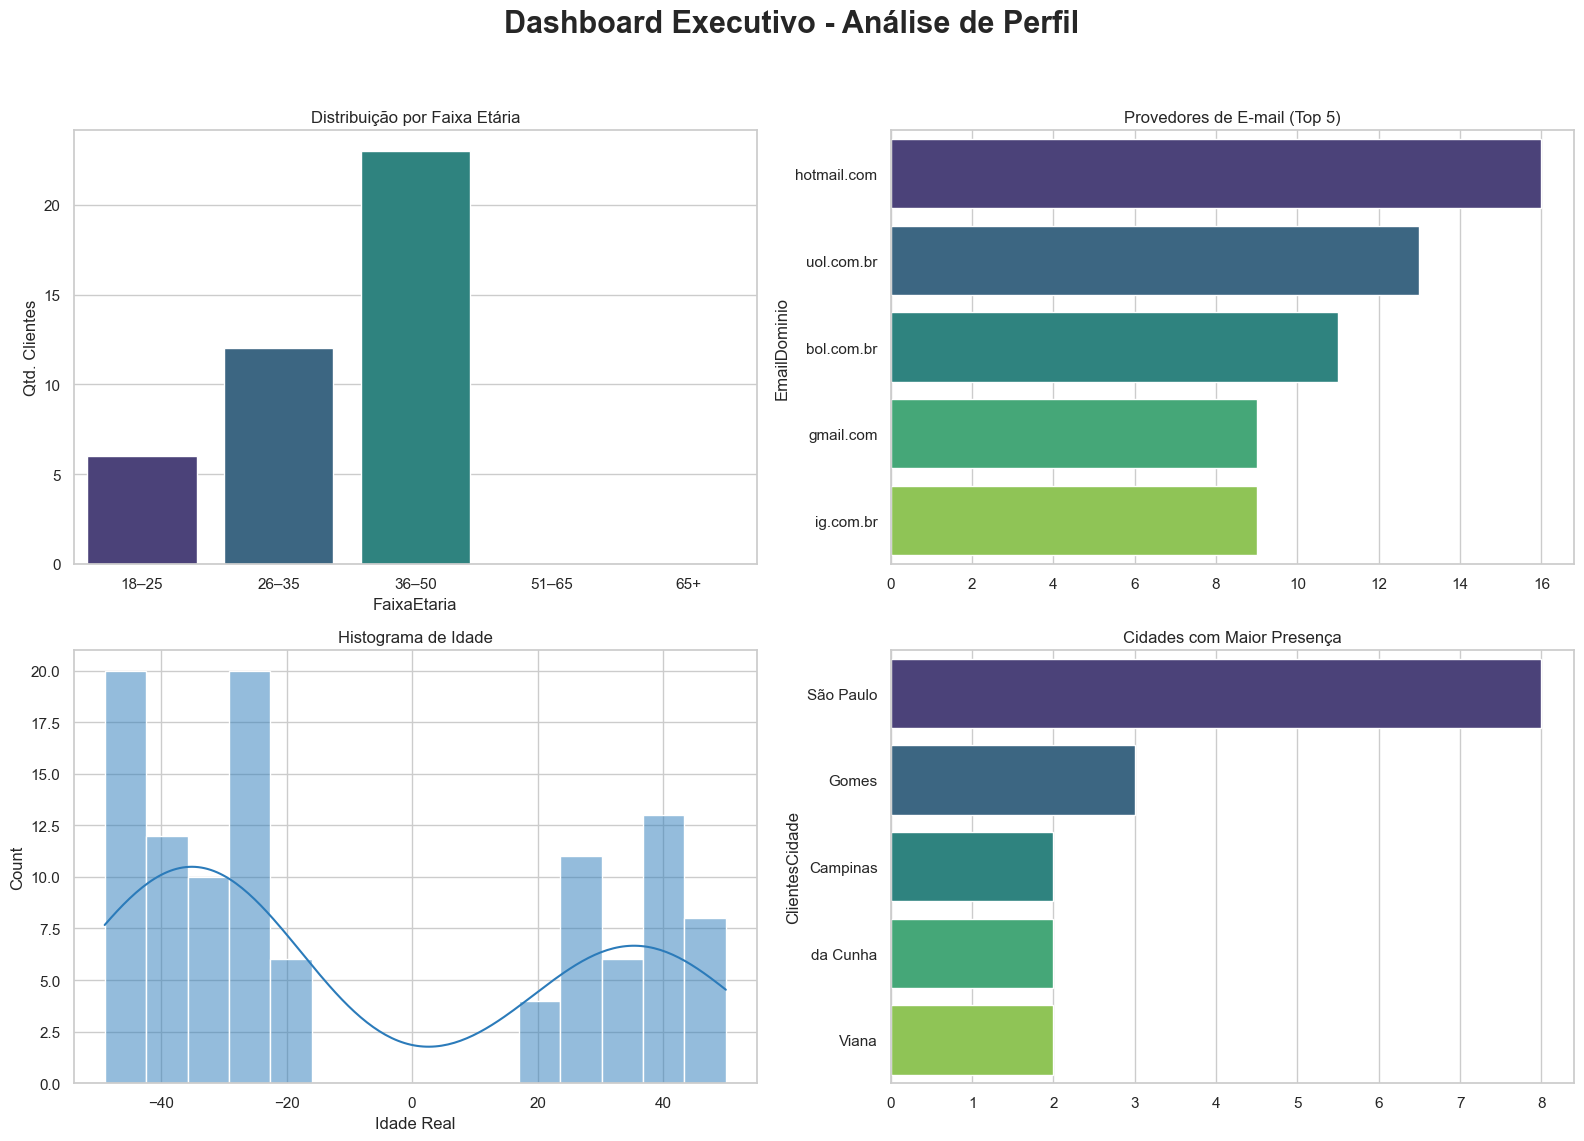

In [5]:
"""
===========================================================
 PETSHOP: ANÁLISE DE CLIENTES (VERSÃO PROFISSIONAL - 3.0)
===========================================================

Melhorias Aplicadas:
--------------------
1. Padronização Visual (Cores corporativas).
2. Validação via Regex e limpeza de caracteres.
3. Funções utilitárias para evitar repetição de código (DRY).
4. Seleção dinâmica de colunas numéricas.
5. Regras de negócio estritas (Faixa Etária 18+).
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re  # Importando biblioteca de Expressões Regulares

# Configuração Visual Padronizada
sns.set(style="whitegrid")
PALETA_CORP = "viridis"  # Paleta única para consistência visual


# Função utilitária para displays (Refinamento 6)
def imprimir_secao(titulo, dados):
    """Função auxiliar para padronizar a saída no terminal."""
    print(f"\n> {titulo.upper()}")
    print("-" * 40)
    print(dados)
    print("-" * 40)


# ===========================================================
#  CARREGAMENTO
# ===========================================================
file_path = "PETSHOP_CLIENTES_110.csv"

try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"CRÍTICO: Arquivo '{file_path}' não encontrado.")
    exit()
except Exception as e:
    df = pd.read_csv(file_path, encoding="latin1")

if df.empty:
    exit()

# ===========================================================
#  LIMPEZA E ENGENHARIA DE DADOS
# ===========================================================

# 1. Data
df["ClientesNascimento"] = pd.to_datetime(
    df["ClientesNascimento"], dayfirst=True, errors="coerce"
)

# 2. Idade
hoje = datetime.now()
df["Idade"] = df["ClientesNascimento"].apply(
    lambda x: (
        (hoje.year - x.year - ((hoje.month, hoje.day) < (x.month, x.day)))
        if pd.notnull(x)
        else None
    )
)

# 3. Faixa Etária (Refinamento 1: Começando estritamente de 18)
# Quem tiver menos de 18 ficará como NaN (Nulo), o que é correto para filtro.
bins = [18, 25, 35, 50, 65, 120]
labels = ["18–25", "26–35", "36–50", "51–65", "65+"]
df["FaixaEtaria"] = pd.cut(df["Idade"], bins=bins, labels=labels, right=True)

# 4. Tratamento de E-mail
df["ClientesEmail"] = df["ClientesEmail"].astype(str).apply(lambda x: x.split("#")[0])
df["EmailDominio"] = df["ClientesEmail"].str.extract(r"@(.+)$")

# ===========================================================
#  VALIDAÇÃO AVANÇADA (Refinamentos 2 e 3)
# ===========================================================

# Função lambda para limpar tudo que NÃO for número
limpar_numeros = lambda x: re.sub(r"\D", "", str(x))

# Criamos colunas temporárias limpas apenas para validação
# CEP: Deve ter 8 dígitos (independente de ter traço ou ponto no original)
df["Validacao_CEP"] = (
    df["ClientesCEP"].apply(limpar_numeros).apply(lambda x: len(x) == 8)
)

# Telefone: Deve ter 10 ou 11 dígitos (DDD + Número)
df["Validacao_Tel"] = (
    df["ClientesTelefone"].apply(limpar_numeros).apply(lambda x: 10 <= len(x) <= 11)
)

# Idade: Regra de Negócio (18 a 95 anos)
df["Validacao_Idade"] = df["Idade"].apply(
    lambda x: 18 <= x <= 95 if pd.notnull(x) else False
)

# ===========================================================
#  INDICADORES E CORRELAÇÃO
# ===========================================================

# KPIs
total_clientes = df["ClientesCodigo"].nunique()
idade_media = df["Idade"].mean()

# Contagem de Inconsistências (Invertendo a lógica booleana com ~)
erros_cep = (~df["Validacao_CEP"]).sum()
erros_tel = (~df["Validacao_Tel"]).sum()
erros_idade = (~df["Validacao_Idade"]).sum()

# Correlação Dinâmica (Refinamento 4)
# Excluímos 'ClientesCodigo' pois ID não tem valor estatístico de correlação
cols_numericas = df.drop(columns=["ClientesCodigo"], errors="ignore").select_dtypes(
    include="number"
)
matriz_correlacao = cols_numericas.corr()

# Agrupamentos
top_bairros = df["ClientesBairro"].value_counts().head(5)
top_cidades = df["ClientesCidade"].value_counts().head(5)
dist_faixa = df["FaixaEtaria"].value_counts().sort_index()

# ===========================================================
#  DASHBOARD TEXTUAL (Usando função utilitária)
# ===========================================================

print("\n=== RELATÓRIO DE QUALIDADE DE DADOS E PERFIL ===")

imprimir_secao(
    "Resumo Geral",
    f"Total Clientes: {total_clientes}\n" f"Idade Média:    {idade_media:.1f} anos",
)

imprimir_secao(
    "Auditoria de Qualidade (Inconsistências)",
    f"CEPs Inválidos:       {erros_cep}\n"
    f"Telefones Inválidos:  {erros_tel}\n"
    f"Idades Fora da Regra: {erros_idade}",
)

imprimir_secao("Top 5 Bairros", top_bairros)
imprimir_secao("Distribuição Etária", dist_faixa)

print(f"\n> CORRELAÇÃO ENTRE VARIÁVEIS NUMÉRICAS")
print(matriz_correlacao)
print("-" * 40)

# ===========================================================
#  DASHBOARD VISUAL (Refinamento 5: Visual Corporativo)
# ===========================================================

plt.figure(figsize=(16, 12))
plt.suptitle("Dashboard Executivo - Análise de Perfil", fontsize=22, weight="bold")

# Gráfico 1: Faixa Etária
plt.subplot(2, 2, 1)
sns.barplot(
    x=dist_faixa.index,
    y=dist_faixa.values,
    hue=dist_faixa.index,
    legend=False,
    palette=PALETA_CORP,  # Cor unificada
)
plt.title("Distribuição por Faixa Etária")
plt.ylabel("Qtd. Clientes")

# Gráfico 2: Domínios (Top 5 para ficar mais limpo)
top_dominios = df["EmailDominio"].value_counts().head(5)
plt.subplot(2, 2, 2)
sns.barplot(
    x=top_dominios.values,
    y=top_dominios.index,
    hue=top_dominios.index,
    legend=False,
    palette=PALETA_CORP,
)
plt.title("Provedores de E-mail (Top 5)")

# Gráfico 3: Histograma (KDE)
plt.subplot(2, 2, 3)
sns.histplot(
    df["Idade"].dropna(), bins=15, kde=True, color="#2b7bba"
)  # Azul corporativo específico
plt.title("Histograma de Idade")
plt.xlabel("Idade Real")

# Gráfico 4: Top Cidades
plt.subplot(2, 2, 4)
sns.barplot(
    x=top_cidades.values,
    y=top_cidades.index,
    hue=top_cidades.index,
    legend=False,
    palette=PALETA_CORP,
)
plt.title("Cidades com Maior Presença")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()